# Savings from a battery and solar system during ERCOT 4CP events

We're going to look at if solar equipped homes stored all excess energy produced on the day of a 4CP event between 7AM until 4PM, then started discharging it from 4-5:30PM. How much energy would be stored up, and what would the potential savings of that be based on a cost of $55/kWh.

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sqla
import os
from config.read_config import get_database_config
import sys
%matplotlib inline
sys.executable  # shows you your path to the python you're using

'/Library/Developer/CommandLineTools/usr/bin/python3'

In [202]:
# read in db credentials from config/config.txt
# * make sure you add those to the config/config.txt file! *

database_config = get_database_config("./config/config.txt")


In [203]:
# get our DB connection
engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))


In [204]:
# Set the cost of a kWh in dollars
cost_kWh = 55

# These are the ERCOT 4CP events (start date/time and end date/time) for 2016 - 2019 acquired from
# http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13037&reportTitle=Planned%20Service%20Four%20Coincident%20Peak%20Calculations&showHTMLView=&mimicKey

event_days = ['2019-06-19', '2019-07-30', '2019-08-12', '2019-09-06',
               '2018-06-27', '2018-07-19', '2018-08-23', '2018-09-19',
               '2017-06-23', '2017-07-28', '2017-08-16', '2017-09-20',
               '2016-06-15', '2016-07-14', '2016-08-11', '2016-09-19'
              ]

# we're going to look at using 7AM to 4PM to charge the theoretical battery as the time the sun becomes available to the PV systems 
# until the earliest possible time of a 4CP event (4PM), then discharge from 4PM - 5:30PM to cover any 4CP timeslots that have happened thus far
start_time = '07:00:00-05'
end_time   = '16:00:00-05'

# these are the actual 4CP event start times and end times from 2016-2019 for reference
event_start_dates = ['2019-06-19 17:00:00-05', '2019-07-30 16:30:00-05', '2019-08-12 17:00:00-05', '2019-09-06 16:45:00-05',
               '2018-06-27 17:00:00-05', '2018-07-19 17:00:00-05', '2018-08-23 16:45:00-05', '2018-09-19 16:30:00-05',
               '2017-06-23 16:45:00-05', '2017-07-28 17:00:00-05', '2017-08-16 17:00:00-05', '2017-09-20 16:45:00-05',
               '2016-06-15 17:00:00-05', '2016-07-14 16:00:00-05', '2016-08-11 16:30:00-05', '2016-09-19 16:15:00-05'
              ]
event_end_dates = ['2019-06-19 17:15:00-05', '2019-07-30 16:45:00-05', '2019-08-12 17:15:00-05', '2019-09-06 17:00:00-05',
               '2018-06-27 17:15:00-05', '2018-07-19 17:15:00-05', '2018-08-23 17:00:00-05', '2018-09-19 16:45:00-05',
               '2017-06-23 17:00:00-05', '2017-07-28 17:15:00-05', '2017-08-16 17:15:00-05', '2017-09-20 17:00:00-05',
               '2016-06-15 17:15:00-05', '2016-07-14 16:15:00-05', '2016-08-11 16:45:00-05', '2016-09-19 16:30:00-05'
                  ]

In [205]:
# let's select homes that have solar and a high amount of data completeness
# we're also filtering out homes that have really large solar arrays (larger than 6.25)
# we're excluding dataids 5448, 2925 due to having a battery already
query = """
select dataid, pv, total_amount_of_pv
from other_datasets.metadata
where pv is not null
and grid is not null 
and solar is not null
and total_amount_of_pv is not null
and total_amount_of_pv <= 6.25
and egauge_1min_min_time < '2016-06-15'
and egauge_1min_max_time > '2019-09-06'
and dataid not in (5448, 2925)
and (egauge_1min_data_availability like '%100%' or egauge_1min_data_availability like '99%' or egauge_1min_data_availability like '98%')
"""

# create a Pandas dataframe with the data from the sql query
dataids = pd.read_sql_query(sqla.text(query), engine)
dataids.head(10)

,dataid,pv,total_amount_of_pv
0,5749,yes,3.200
1,3310,yes,6.125
2,6691,yes,5.200
3,7030,yes,5.250
4,3368,yes,5.000
5,9776,yes,6.000
6,3506,yes,6.240
7,8645,yes,4.500
8,7875,yes,4.100
9,7017,yes,5.920


In [206]:
dataids.describe()

,dataid,total_amount_of_pv
count,60.000000,60.000000
mean,5154.866667,5.133783
std,2942.103182,1.228952
min,93.000000,0.700000
25%,2984.500000,4.480000
50%,5580.000000,5.375000
75%,7655.000000,6.105000
max,9971.000000,6.250000


In [207]:
# extract the dataids
# grab dataids and convert them to a string to put into the SQL query
dataids_list = dataids['dataid'].tolist()
print("{} dataids selected listed here:".format(len(dataids_list)))
dataids_str = ','.join(list(map(str, dataids_list)))
dataids_str
# dataids_list

60 dataids selected listed here:


'5749,3310,6691,7030,3368,9776,3506,8645,7875,7017,5109,3829,6121,8086,9971,9052,7850,7739,7627,7108,6578,5796,5738,5129,2986,2980,2470,1792,1169,1103,252,9942,9932,7989,6139,5218,93,5439,171,5892,5615,4357,2199,9160,9134,8317,7504,7016,5545,3967,3482,3039,3009,2814,744,545,781,7965,1718,114'

In [208]:
# select the data for all of the events for all of these homes starting at 7AM and ending at 4PM
# the first date starting at midnight and ending at the end time of one of the 4CP events

first_start = event_days.pop(0)
energy_query = """
select dataid, localminute, solar, grid from electricity.eg_realpower_1min 
where ((localminute >= '{} {}' and localminute <= '{} {}') """.format(first_start, start_time, first_start, end_time)

for day in event_days:
    energy_query = energy_query + "OR (localminute >= '{} {}' and localminute <= '{} {}') ".format(day, start_time, day, end_time)

energy_query = energy_query + """ ) AND dataid in ({})""".format(dataids_str)

print("query is {}".format(energy_query))

df2 = pd.read_sql_query(sqla.text(energy_query), engine)

query is 
select dataid, localminute, solar, grid from electricity.eg_realpower_1min 
where ((localminute >= '2019-06-19 07:00:00-05' and localminute <= '2019-06-19 16:00:00-05') OR (localminute >= '2019-07-30 07:00:00-05' and localminute <= '2019-07-30 16:00:00-05') OR (localminute >= '2019-08-12 07:00:00-05' and localminute <= '2019-08-12 16:00:00-05') OR (localminute >= '2019-09-06 07:00:00-05' and localminute <= '2019-09-06 16:00:00-05') OR (localminute >= '2018-06-27 07:00:00-05' and localminute <= '2018-06-27 16:00:00-05') OR (localminute >= '2018-07-19 07:00:00-05' and localminute <= '2018-07-19 16:00:00-05') OR (localminute >= '2018-08-23 07:00:00-05' and localminute <= '2018-08-23 16:00:00-05') OR (localminute >= '2018-09-19 07:00:00-05' and localminute <= '2018-09-19 16:00:00-05') OR (localminute >= '2017-06-23 07:00:00-05' and localminute <= '2017-06-23 16:00:00-05') OR (localminute >= '2017-07-28 07:00:00-05' and localminute <= '2017-07-28 16:00:00-05') OR (localminute >= '

In [209]:
df2.describe()

,dataid,solar,grid
count,515929.000000,509858.000000,507153.000000
mean,5164.411516,1.976789,-0.141027
std,2921.227313,1.398884,2.096861
min,93.000000,-0.080000,-6.100000
25%,2986.000000,0.605000,-1.639000
50%,5615.000000,2.048000,-0.098000
75%,7739.000000,3.150000,0.903000
max,9971.000000,8.377000,20.753000


In [210]:
# calculate usage as grid minus solar (which is actually grid + solar because solar is negative use)
# Calculate the difference with a lambda function and add it as a new column called 'usage'

# NOTE: This takes a while to run, after all it's running this lambda function on ~520k points
df2['usage'] = df2.apply(lambda row: row.solar + row.grid, axis=1)
df2.describe()

,dataid,solar,grid,usage
count,515929.000000,509858.000000,507153.000000,507153.000000
mean,5164.411516,1.976789,-0.141027,1.822159
std,2921.227313,1.398884,2.096861,1.989233
min,93.000000,-0.080000,-6.100000,0.000000
25%,2986.000000,0.605000,-1.639000,0.358000
50%,5615.000000,2.048000,-0.098000,0.818000
75%,7739.000000,3.150000,0.903000,3.045000
max,9971.000000,8.377000,20.753000,27.363000


In [211]:
# what's going on with the neg usage?
wat = df2.loc[df2['usage'] < 0]
wat.dataid.unique()

array([], dtype=int64)

In [212]:
# convert localminute to pandas datetime type
df2['datetime'] = pd.to_datetime(df2['localminute'])

# and set as index
df2 = df2.set_index('datetime')

# set local timezone
df2 = df2.tz_convert('US/Central')

df2

,dataid,localminute,solar,grid,usage
datetime,,,,,
2016-06-15 07:00:00-05:00,781,2016-06-15 12:00:00+00:00,-0.002,0.612,0.610
2016-06-15 07:01:00-05:00,781,2016-06-15 12:01:00+00:00,0.066,0.547,0.613
2016-06-15 07:02:00-05:00,781,2016-06-15 12:02:00+00:00,0.070,0.529,0.599
2016-06-15 07:03:00-05:00,781,2016-06-15 12:03:00+00:00,0.077,0.503,0.580
2016-06-15 07:04:00-05:00,781,2016-06-15 12:04:00+00:00,0.084,0.498,0.582
...,...,...,...,...,...
2019-09-06 16:00:00-05:00,8317,2019-09-06 21:00:00+00:00,1.419,-1.112,0.307
2019-09-06 16:00:00-05:00,1169,2019-09-06 21:00:00+00:00,1.980,-1.554,0.426
2019-09-06 16:00:00-05:00,7627,2019-09-06 21:00:00+00:00,2.237,3.321,5.558


In [213]:

# group by month and dataid and sum negative grid grouping into month by dataid giving us each home's accumulated negative grid 
# (extra solar production) for that month's 4CP event day between 7AM and 4PM
df3 = df2.loc[df2['grid'] < 0].groupby([pd.Grouper(freq='M'), 'dataid']).sum()
df3

solar      grid    usage
datetime                  dataid                             
2016-06-30 00:00:00-05:00 93      1316.403 -1111.604  204.799
                          114      735.877  -616.355  119.522
                          171     1144.156  -553.947  590.209
                          252      300.220  -174.266  125.954
                          545      553.886  -381.549  172.337
...                                    ...       ...      ...
2019-09-30 00:00:00-05:00 9160      20.477   -10.971    9.506
                          9776     586.117  -147.639  438.478
                          9932    1110.050  -767.102  342.948
                          9942      27.148    -1.520   25.628
                          9971    1165.505 -1005.654  159.851

[916 rows x 3 columns]

In [214]:
# we're going to have a look at what happens when we average them all together by month 
df4 = df3.reset_index()
df4 = df4.set_index('datetime')
df4 = df4.groupby([pd.Grouper(freq='M')]).mean()

# drop all rows that are all NaN
df4 = df4.dropna(thresh=3)

# drop all the dataids
df4 = df4.drop(columns=['dataid'])

# convert to KWh
df4 = df4.apply(lambda x : x / 60.0)

# this gives us the 16 event days averaged together per day
df4

,solar,grid,usage
datetime,,,
2016-06-30 00:00:00-05:00,13.925021,-9.463791,4.461230
2016-07-31 00:00:00-05:00,13.162215,-8.895962,4.266253
2016-08-31 00:00:00-05:00,11.537654,-7.677900,3.859754
2016-09-30 00:00:00-05:00,12.787080,-8.739547,4.047532
2017-06-30 00:00:00-05:00,12.173504,-8.381909,3.791595
2017-07-31 00:00:00-05:00,12.019359,-8.303906,3.715453
2017-08-31 00:00:00-05:00,12.445309,-8.131893,4.313416
2017-09-30 00:00:00-05:00,11.923586,-8.345361,3.578225
2018-06-30 00:00:00-05:00,12.223695,-7.983508,4.240187


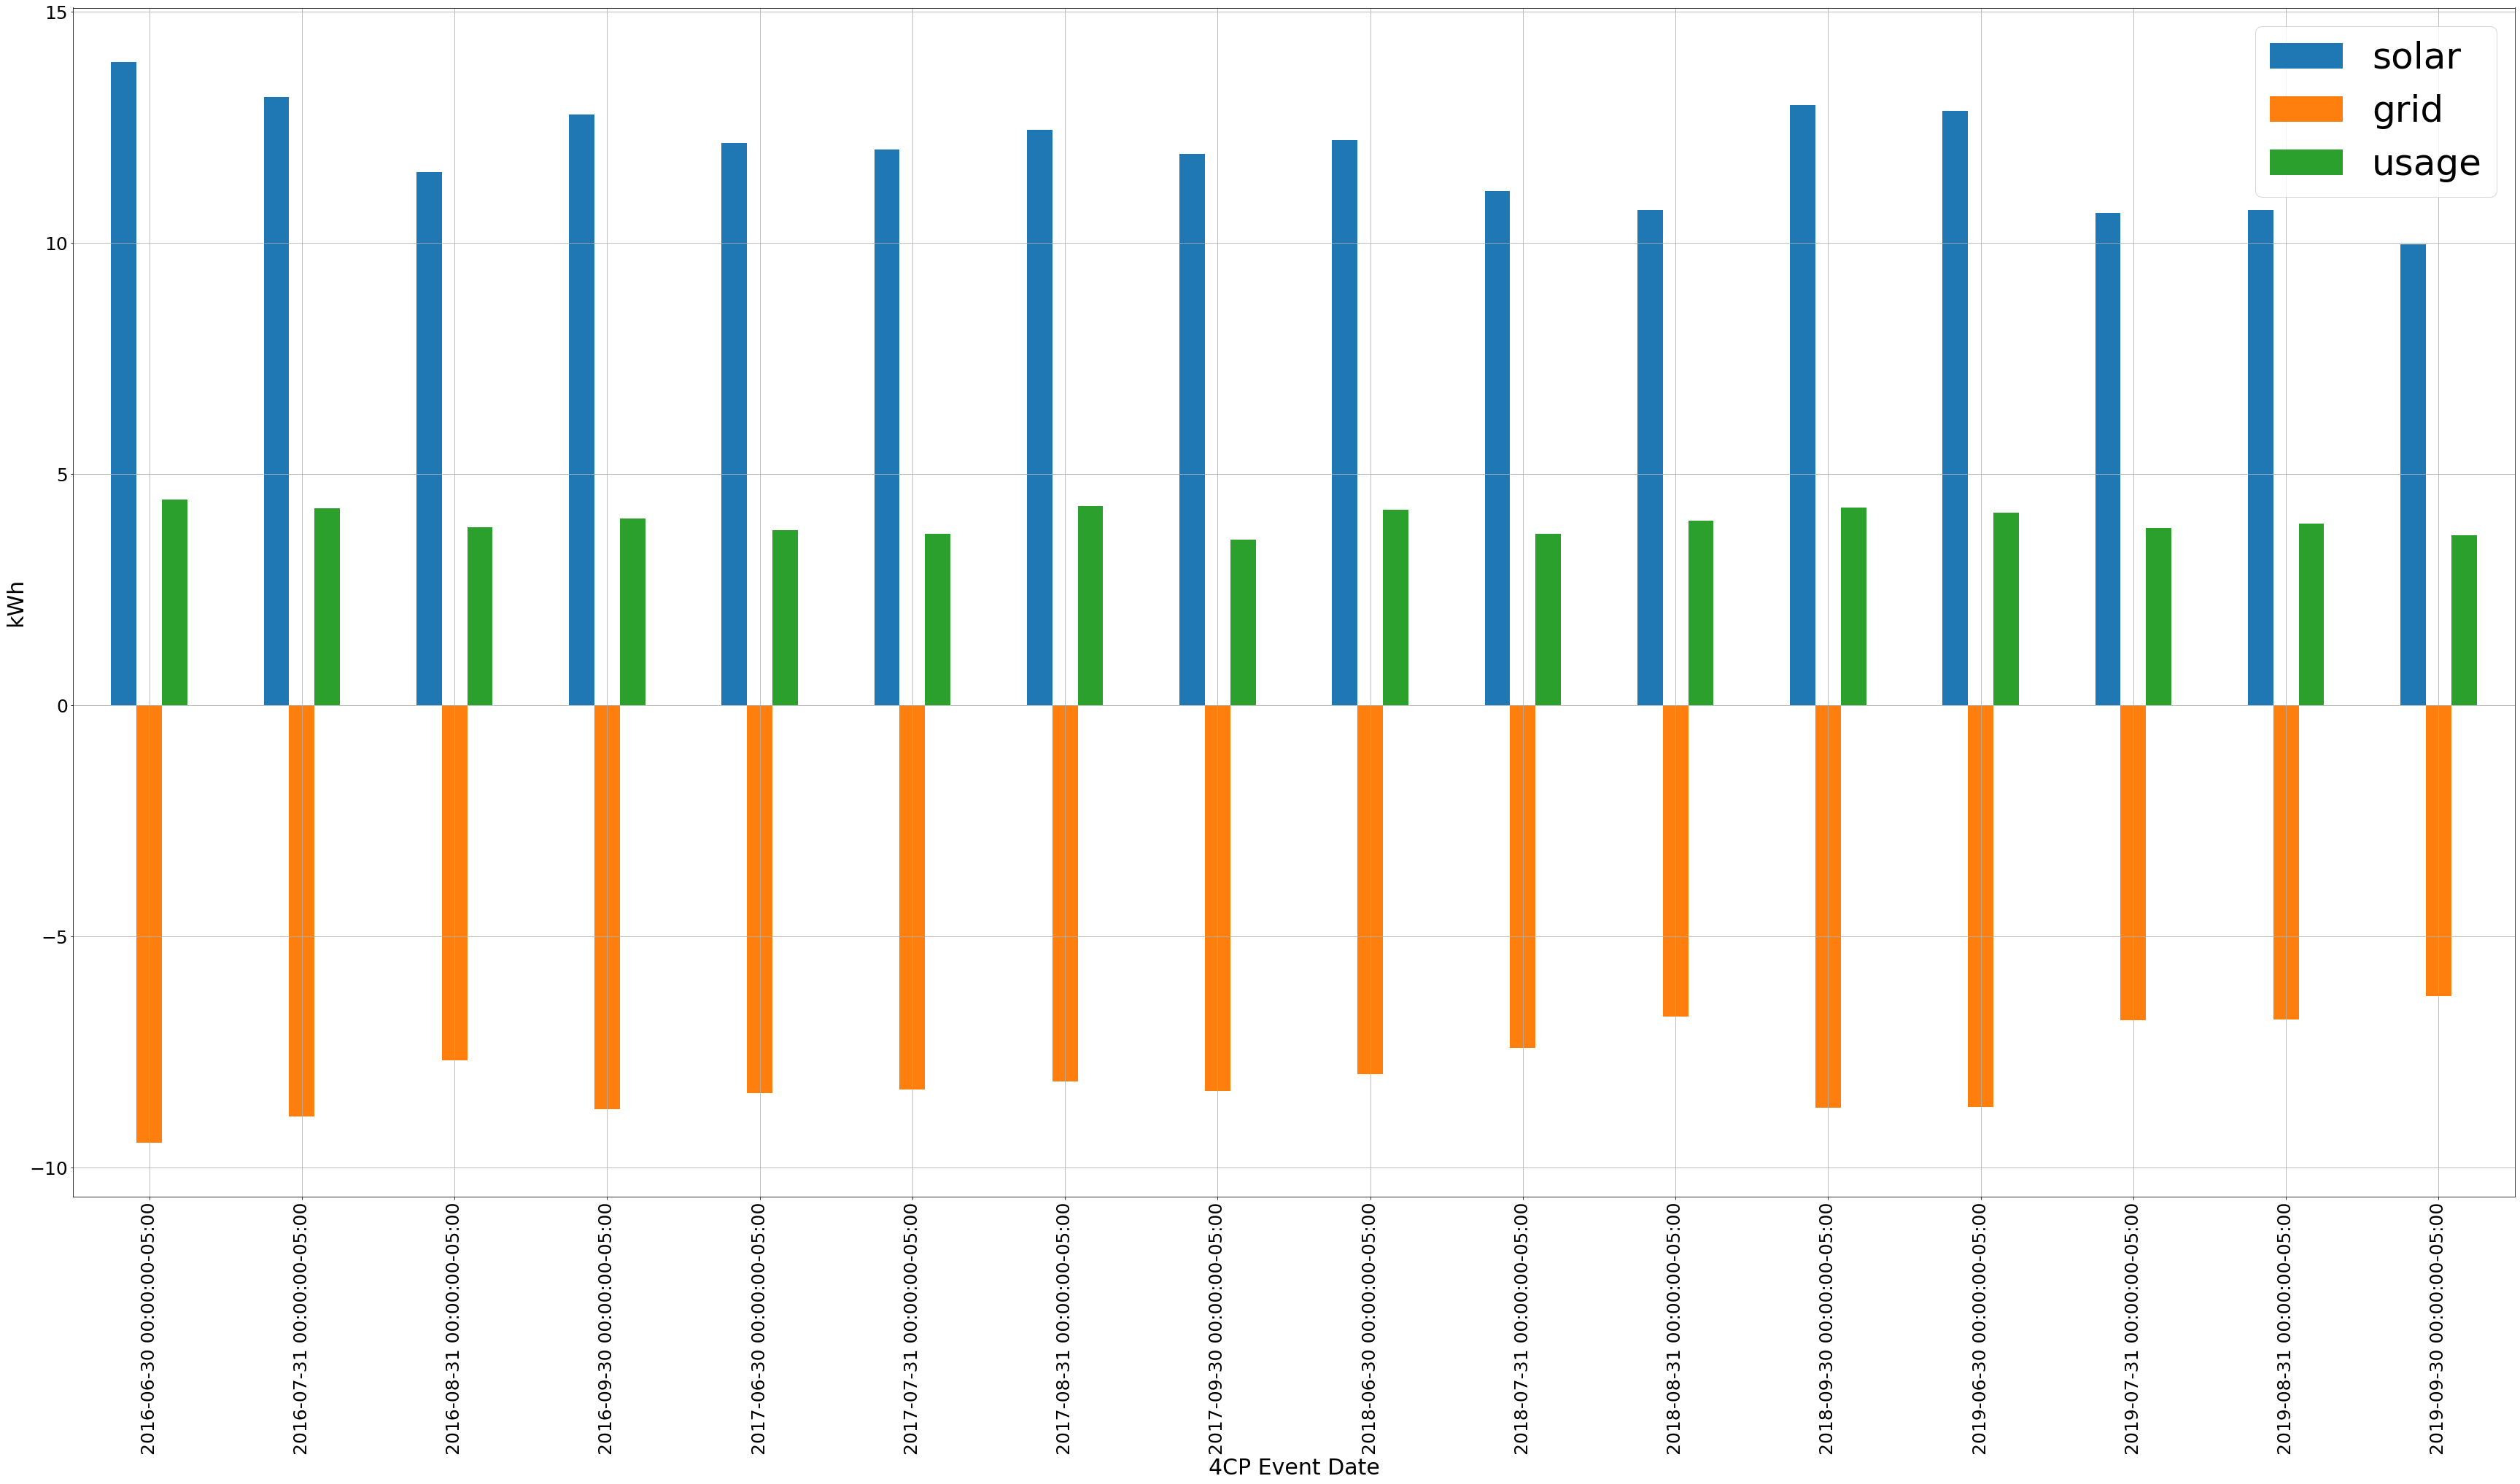

In [215]:
# let's put this all on a bar chart with a set of solar/grid/usage per day
ax = df4.plot.bar(rot=90, figsize=[60,30], fontsize=25, grid=True)
ax.set_xlabel('4CP Event Date', fontsize = 30)
ax.set_ylabel('kWh', fontsize = 30)
legend = ax.legend(loc=1, prop={'size': 50})

In [216]:
# OK, back to the 3rd dataframe before we averaged them all together by month when we simply had grouped by month and dataid 
# and taken a sum of the rows with negative grid

# let's drop the usage and solar columns now that we'll only be working with the grid column
df3 = df3.drop(columns=['solar','usage'])
df3.describe()

,grid
count,916.000000
mean,-477.987608
std,323.690542
min,-1866.704000
25%,-700.619500
50%,-448.916000
75%,-210.082750
max,-0.014000


In [217]:
# average that entire negative grid column
ave_neg = df3.mean()
ave_neg.grid

-477.98760807860265

In [218]:
# convert summed up usage to give us kWh by dividing by 60 (one minute data / 60 because there are 60 minutes per hour)
kWh = ave_neg.grid / 60
kWh

-7.966460134643378

In [219]:
# divide by 1.5 to calculate the kW discharged over the 1.5 hours of the time between 4PM and 5:30PM to cover the potential 4CP event.
kW = kWh / 1.5
kW

-5.310973423095585

In [220]:
# At a rate of $550 / kW how much on average is saved per house if we store up all the solar produced starting at 
# 7AM until 4PM and then discharge to cover the potential 4CP event that day from 4PM - 5:30 PM
value = abs(kW) * cost_kWh
print("Average $ saved per house if they charged their battery day of a 4CP event, then started discharging at 4PM would be ${}".format(str(round(value, 2))))

Average $ saved per house if they charged their battery day of a 4CP event, then started discharging at 4PM would be $292.1
